# Importing required libraries

In [1]:
import os
import math
import librosa
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras.models import Model
# from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Setting the relevant variables and path

In [2]:
DATASET_PATH = r"C:\Users\prink\Desktop\Data science\Artificial intelligence\Assignment2\Original Audio\Data\genres_original"
JSON_PATH = r"data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

# Extracting MFCCs from the dataset and store it in a JSON file

In [3]:
def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    """Extracts MFCCs from music dataset and saves them into a json file along with genre labels.
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)

    # loop through all genre sub-folder
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):

        # ensure we're processing a genre sub-folder level
        if dirpath is not dataset_path:

            # save genre label (i.e., sub-folder name) in the mapping
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))

            # process all audio files in genre sub-dir
            for f in filenames:

                # load audio file
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)

                # process all segments of audio file
                for d in range(num_segments):

                    # calculate start and finish sample for current segment
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # extract mfcc
                    mfcc = librosa.feature.mfcc(signal[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_fft,
                                                hop_length=hop_length)
                    mfcc = mfcc.T

                    # store only mfcc feature with expected number of vectors
                    if len(mfcc) == num_mfcc_vectors_per_segment:
                        data["mfcc"].append(mfcc.tolist())
                        data["labels"].append(i - 1)
                        print("{}, segment:{}".format(file_path, d + 1))

    # save MFCCs to json file
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)


Processing: C:\Users\prink\Desktop\Data science\Artificial intelligence\Assignment2\Original Audio\Data\genres_original\blues
C:\Users\prink\Desktop\Data science\Artificial intelligence\Assignment2\Original Audio\Data\genres_original\blues\blues.00000.wav, segment:1
C:\Users\prink\Desktop\Data science\Artificial intelligence\Assignment2\Original Audio\Data\genres_original\blues\blues.00000.wav, segment:2
C:\Users\prink\Desktop\Data science\Artificial intelligence\Assignment2\Original Audio\Data\genres_original\blues\blues.00000.wav, segment:3
C:\Users\prink\Desktop\Data science\Artificial intelligence\Assignment2\Original Audio\Data\genres_original\blues\blues.00000.wav, segment:4
C:\Users\prink\Desktop\Data science\Artificial intelligence\Assignment2\Original Audio\Data\genres_original\blues\blues.00000.wav, segment:5
C:\Users\prink\Desktop\Data science\Artificial intelligence\Assignment2\Original Audio\Data\genres_original\blues\blues.00000.wav, segment:6
C:\Users\prink\Desktop\Data


# Building Model

In [4]:
DATA_PATH = r"data_10.json"

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 130, 64)           19968     
_________________________________________________________________
lstm_15 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_14 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 5s 16ms/step - loss: 2.2596 - accuracy: 0.1561 - val_loss: 2.

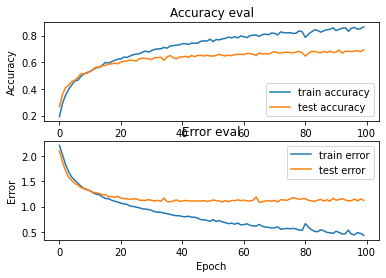

79/79 - 0s - loss: 1.1692 - accuracy: 0.6764

Test accuracy: 0.6764116883277893


In [12]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates RNN-LSTM model
    :param input_shape (tuple): Shape of input set
    :return model: RNN-LSTM model
    """

    # build network topology
    model = keras.Sequential()

    # 2 LSTM layers
    model.add(keras.layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(64))

    # dense layer
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model0 = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model0.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model0.summary()

    # train model
    history = model0.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model0.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

# Learning rate =0.0008

In [ ]:
if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model1 = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0008)
    model1.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model1.summary()

    # train model
    history = model1.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model1.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_18 (LSTM)               (None, 130, 64)           19968     
_________________________________________________________________
lstm_19 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 6s 16ms/step - loss: 2.0439 - accuracy: 0.2606 - val_loss: 1.

# Learning rate = 0.001

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 130, 64)           19968     
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                650       
Total params: 57,802
Trainable params: 57,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
188/188 [==============================] - 6s 17ms/step - loss: 1.9809 - accuracy: 0.2898 - val_loss: 1.

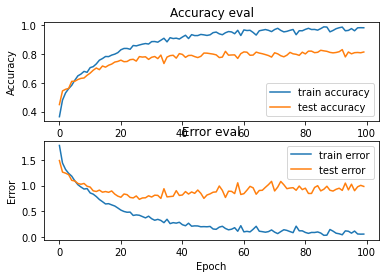

79/79 - 0s - loss: 1.1000 - accuracy: 0.7954

Test accuracy: 0.795354425907135


In [8]:



if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2]) # 130, 13
    model2 = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0008)
    model2.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model2.summary()

    # train model
    history = model2.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model2.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

In [33]:
yhat_classes=model.predict_classes(X_test, verbose=0)
print(yhat_classes[1])
print(y_test[1])

8
3


In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,confusion_matrix
accuracy_score(y_test, yhat_classes)

0.7917501001201441

In [25]:
print(f1_score(y_test, yhat_classes, average="macro"))
precision_score(y_test, yhat_classes, average="macro")

0.7909253553542961


0.7908738167799123

In [27]:
confusion_matrix(y_test, yhat_classes)

array([[219,   0,  16,   9,   7,   4,   2,   0,   3,   7],
       [  1, 246,   1,   0,   0,   7,   0,   0,   0,   1],
       [ 11,   1, 172,  11,   2,  17,   0,   6,   9,  20],
       [  0,   3,   6, 178,   9,   2,   8,   7,   9,  14],
       [  3,   0,   1,  11, 191,   2,   3,   4,  12,   9],
       [  6,  12,  12,   0,   0, 180,   0,   2,   2,  17],
       [  9,   0,   3,   4,   3,   0, 205,   0,   0,  10],
       [  1,   1,   8,  11,  17,   3,   0, 215,   8,   5],
       [  3,   1,   7,   7,  12,   4,   3,   4, 215,   6],
       [ 12,   3,  23,  21,   4,   9,  15,   6,   8, 156]], dtype=int64)